<h1 align="center">
        <picture>
         <source media="(prefers-color-scheme: dark)" srcset="https://user-images.githubusercontent.com/16140783/218357099-29d4848f-89ee-463e-9ead-40f27c976f61.png">
         <img width="300" src="https://user-images.githubusercontent.com/16140783/218437368-1aa8506c-1ed8-460a-99de-d2c081557170.png" align="center"></img>
    </picture><br/><br/>Subvocalization EMG - PoC<sub><sup><br/>(Subvocalization)</sup></sub>
</h1>

Project for recording and training subvocalization **EMG** data with the Cyton Board. This is the final PoC of the project containing the steps of processing and training with real subvocalization data. Developed by **Mateus de Aquino Batista** for the Bachelor's Degree Final Project.


### Packages

First, after recording the raw data with Brainflow, we can start processing the data, so let's start installing the required packages for reading the saves, preprocessing, plotting and training a new model.

In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations, NoiseTypes, AggOperations
from brainflow.board_shim import BoardShim, BoardIds
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from collections import defaultdict
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import np_utils
import os

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

os.chdir('../')

### Reading raw EMG data

The sEMG data will be read from the Cyton Dongle through [BrainFlow](https://brainflow.readthedocs.io/en/stable/SupportedBoards.html#cyton), you can also check the [Code Samples](https://brainflow.readthedocs.io/en/stable/Examples.html) section to know how to get the data from the board and read/write it to a csv file.

In [2]:
csv = pd.read_csv("dist/saves/P010/F/Talvez.csv")
emg_channels = [1, 2, 3, 4]
df_channels = list(map(lambda x: "Channel_%s" % (x), emg_channels))

csv

,WORD,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,talvez,27111.526085,-20712.288703,-20199.919665,37553.143508,-187500.022352,-187500.022352,-187500.022352,-187500.022352
1,talvez,27642.916458,-21021.346274,-19496.063232,37337.672691,-187500.022352,-187500.022352,-187500.022352,-187500.022352
2,talvez,28770.696076,-20993.920683,-18817.978360,37403.543282,-187500.022352,-187500.022352,-187500.022352,-187500.022352
3,talvez,28457.637543,-20728.694883,-19332.604925,37591.476749,-187500.022352,-187500.022352,-187500.022352,-187500.022352
4,talvez,27260.299296,-20674.067220,-20132.864431,37582.536052,-187500.022352,-187500.022352,-187500.022352,-187500.022352
...,...,...,...,...,...,...,...,...,...
22429,talvez,27552.280134,-20392.882275,-18927.434853,36845.308464,-187500.022352,-187500.022352,-187500.022352,-187500.022352
22430,talvez,28579.968641,-20487.519561,-17881.082640,36844.101470,-187500.022352,-187500.022352,-187500.022352,-187500.022352
22431,talvez,29453.184241,-20374.978527,-17394.306349,36998.261452,-187500.022352,-187500.022352,-187500.022352,-187500.022352
22432,talvez,28558.980353,-20376.252577,-18418.709149,36925.752393,-187500.022352,-187500.022352,-187500.022352,-187500.022352


We can plot the data for each channel directly to [Matplotlib](https://matplotlib.org/). As you could tell, these graphing tools have a way higher resolution than the one used in the frontend for debugging ([Chart.js](https://www.chartjs.org/)).

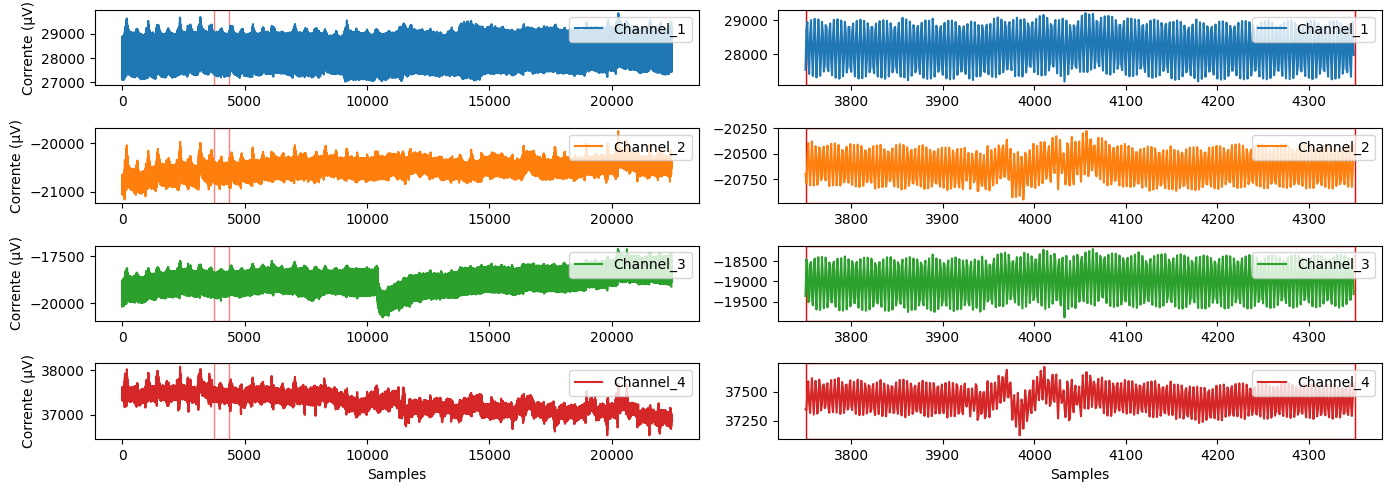

In [3]:
restored_data = csv.copy()

window = 600
offset = 4050
start = offset-int(window/2)
end = offset+int(window/2)

f, axarr = plt.subplots(len(emg_channels), 2, figsize=(14,5))
axs = restored_data[df_channels].plot(subplots=True, ax=axarr[:,0])
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")
    axs[i].axvspan(start, end, alpha=0.5, ec='red', fill=False)
    axs[i].set_ylabel('Corrente (µV)')
axs[3].set_xlabel('Samples')
    
axs = restored_data[df_channels][start:end].plot(subplots=True, ax=axarr[:,1])
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")
    axs[i].axvspan(start, end, alpha=1, ec='red', fill=False)
axs[3].set_xlabel('Samples')
    
plt.tight_layout(pad=1.0)
plt.show()

### Preprocessing

As we're only using 4 channels, we can perform a Butterworth filter on them to select the frequency range we want to keep, here we apply the filtering and denoising. Also, let's define a plot function to visualize the terms heatmap after processing the data:

In [5]:
from numpy.fft import fft, ifft

board_id = BoardIds.CYTON_BOARD.value
sampling_rate = BoardShim.get_sampling_rate(board_id)
exg_channels = BoardShim.get_exg_channels(board_id)

def plot(restored_data, plots=6):
    if plots%7==0:
      offset = 1500
      plt.figure()
      _f, axarr = plt.subplots(len(emg_channels), 1, constrained_layout=True, figsize=(8, len(emg_channels)*2))
      for i, channel in enumerate(df_channels):
        X = fft(restored_data[channel][offset:offset+sampling_rate*10])
        N = len(X)
        n = np.arange(N)
        T = N/sampling_rate
        freq = n/T 

        axarr[i].stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")
        axarr[i].set_xlabel('Freq (Hz)')
        axarr[i].set_ylabel('FFT Amplitude |X(freq)|')
        #axarr[i].set_xlim(0, 60)
        axarr[i].set_title('Após Butterworth (bandstop em 115Hz à 135Hz)')
      plt.show()

    window = 600
    offset = 4050
    start = offset-int(window/2)
    end = offset+int(window/2)

    if plots%2==0:
      f, axarr = plt.subplots(len(emg_channels), 2, figsize=(14,5))
      axs = restored_data[df_channels].plot(subplots=True, ax=axarr[:,0])
      for i,ax in enumerate(axs):
          axs[i].legend(loc="upper right")
          axs[i].axvspan(start, end, alpha=0.5, ec='red', fill=False)
          axs[i].set_ylabel('Corrente (µV)')
      axs[3].set_xlabel('Samples')
    
      axs = restored_data[df_channels][start:end].plot(subplots=True, ax=axarr[:,1])
      for i,ax in enumerate(axs):
          axs[i].legend(loc="upper right")
          axs[i].axvspan(start, end, alpha=1, ec='red', fill=False)
      axs[3].set_xlabel('Samples')

      plt.tight_layout(pad=1.0)
      plt.show()
    
    emg_words = []
    emg_data = []
    
    total_samples = len(restored_data['Channel_1'])
    samples = 220
    words_to_visualize = 10
    words_offset = 20
    
    words_end = words_offset + words_to_visualize
    
    x = restored_data.drop(restored_data.columns[0],axis=1).to_numpy()
    preprocessed_data = x[:, :len(emg_channels)]
    
    word = None
    data = None
    for i in range(len(preprocessed_data)):
      if (plots%5!=0 and len(emg_words) == words_offset+30) or (plots%5!=0 and len(emg_words) == words_end): break
      if i == 0:
        word = csv.iloc[0, 0]
        data = preprocessed_data[0, :]
      elif csv.iloc[i, 0] == word:
        data = np.vstack((data, preprocessed_data[i, :]))
      else:
        emg_words.append(word)
        emg_data.append(data)
        word = csv.iloc[i, 0]
        data = preprocessed_data[i, :]
    
    emg_words.append(word)
    emg_data.append(data)

    if plots%3==0:
      plt.figure()
      _f, axarr = plt.subplots(words_to_visualize, 1, constrained_layout=True, figsize=(10, words_to_visualize*2/3))
      for i, word in enumerate(emg_words[words_offset:words_end]):
          axarr[i].imshow(np.transpose(emg_data[words_offset+i]), cmap='hot', interpolation='none', aspect=2)
          print(len(emg_data[words_offset+i]))
          axarr[i].set_ylabel(word, fontsize=12, y=.20, ha='right', rotation='horizontal', labelpad=10) 
      plt.show()
        
    words_each = 3

    words_grouped = defaultdict(list)
    for i, word in enumerate(emg_words[words_offset:]):
        words_grouped[word].append(words_offset+i)
    words_grouped = words_grouped.items()
    words_grouped = dict((key, tuple(val)) for key, val in words_grouped)
    
    if plots%5==0:
      plt.figure()
      _f, axarr = plt.subplots(len(words_grouped)*words_each, 1, constrained_layout=True, figsize=(10, (len(words_grouped)*words_each)*2/3))
      for i, word in enumerate(words_grouped):
          for j, index in enumerate(words_grouped[word][:words_each]):
              axarr[i*words_each+j].imshow(np.transpose(emg_data[index]), cmap='hot', interpolation='none', aspect=2)
              axarr[i*words_each+j].set_ylabel(word, fontsize=12, y=.20, ha='right', rotation='horizontal', labelpad=10) 
      plt.show()

211
210
226
210
210
224
210
210
226
210


<Figure size 640x480 with 0 Axes>

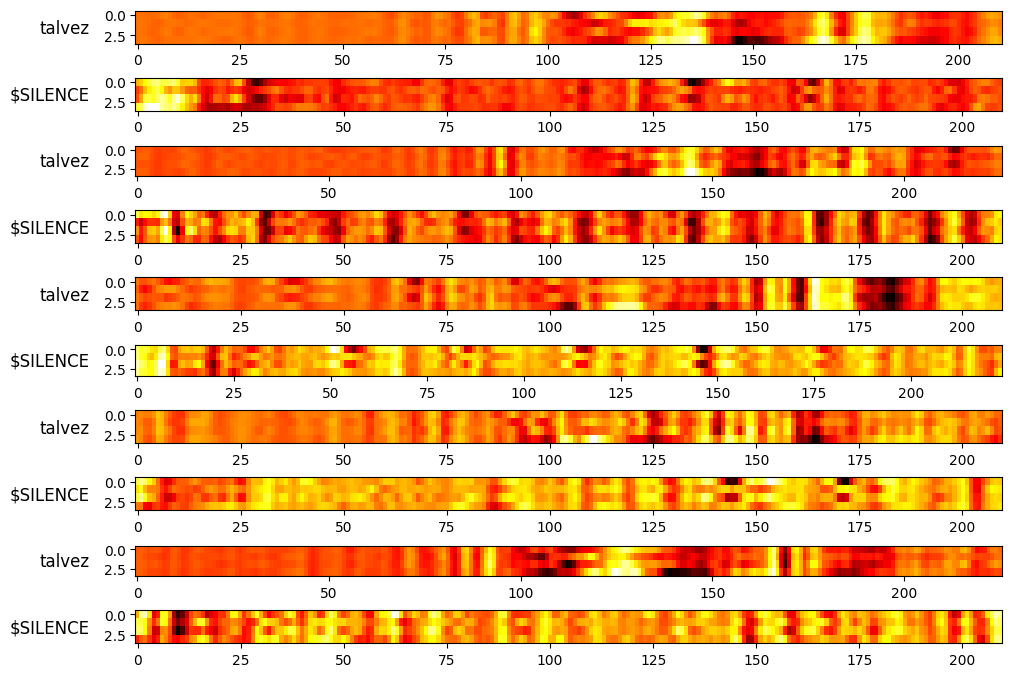

In [6]:
from brainflow.data_filter import DataFilter, AggOperations, WaveletTypes, NoiseEstimationLevelTypes, \
    WaveletExtensionTypes, ThresholdTypes, WaveletDenoisingTypes

restored_data = csv.copy()
for count, channel in enumerate(df_channels):
    if count >= 8:
        continue
    channel_data = restored_data[channel].to_numpy()
    DataFilter.detrend(channel_data, DetrendOperations.CONSTANT.value)
    DataFilter.remove_environmental_noise(channel_data, sampling_rate, NoiseTypes.SIXTY.value);
    DataFilter.perform_bandpass(channel_data, sampling_rate, 5, 230, 4, FilterTypes.BUTTERWORTH.value, 1.0)
    DataFilter.perform_bandstop(channel_data, sampling_rate, 115, 135, 4, FilterTypes.BUTTERWORTH.value, 1.0)
    DataFilter.perform_rolling_filter(channel_data, 3, AggOperations.MEAN.value)

plot(restored_data, 3)

### Training the Neural Network

We need to factorize the words array so we can get an unique list of the words used, and also retreive a list the model can read as an expected output:

Original words count: 315
Original Avg Samples (per word): 212
New words count: 300 (removed 15 words)
New Avg Samples (per word): 215
New Samples: 202 (removed 13 samples from average)


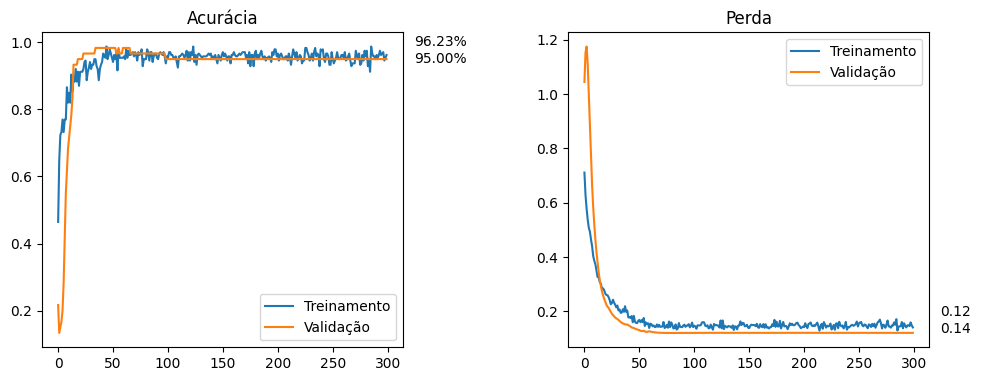

              precision    recall  f1-score   support

    $SILENCE       1.00      0.97      0.99        38
         sim       0.89      0.89      0.89         9
         não       1.00      1.00      1.00         6
      talvez       0.75      0.86      0.80         7

    accuracy                           0.95        60
   macro avg       0.91      0.93      0.92        60
weighted avg       0.95      0.95      0.95        60



In [27]:
from backend.training import train_network

batch_size = 30
epochs = 300
max_channels = 4
window_size = 120

words_map, samples, model, history, classification_report = train_network(80, ["P010/F/Sim", "P010/F/Nao", "P010/F/Talvez"], batch_size, epochs, max_channels, window_size)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

ax1.set_title("Acurácia")
ax1.plot(accuracy, label="Treinamento")
ax1.plot(val_accuracy, label="Validação")
ax1.legend(fontsize="10")

ax2.set_title("Perda")
ax2.plot(loss, label="Treinamento")
ax2.plot(val_loss, label="Validação")
ax2.legend(fontsize="10")

i = 0
for var in (val_accuracy, accuracy):
    i+=1
    ax1.annotate('%2.2f%%' % (var[-1]*100), xy=(1, 0.85), xytext=(8, i*12), 
                 xycoords=('axes fraction', 'axes fraction'), textcoords='offset points')

for var in (loss, val_loss):
    i-=1
    ax2.annotate('%0.2f' % var[-1], xy=(1, 0.1), xytext=(8, -i*12), 
                 xycoords=('axes fraction', 'axes fraction'), textcoords='offset points')


fig.tight_layout(pad=5.0)
plt.show()
print(classification_report)

For clear speech recognition in a single specific participant, we achieved a satisfactory accuracy for both training and validation.

# Training available data

In this step, we trained the data collected from all participants, both collectively and individually, to validate the methodology and identify areas for improvement.

In [15]:
from backend.training import train_network

batch_size = 30
epochs = 300
max_channels = 4
window_size = 120

def train_all(title, items):
  words_map, samples, model, history, classification_report = train_network(80, items, batch_size, epochs, max_channels, window_size)
  fig, axs = plt.subplots()

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  axs.set_title(title)
  axs.plot(accuracy, label="Acurácia (Treinamento)")
  axs.plot(val_accuracy, label="Acurácia (Validação)")
  axs.plot(loss, label="Perda (Treinamento)")
  axs.plot(val_loss, label="Perda (Validação)")
  axs.set_ylim(0,1)
  axs.legend(fontsize="10")

  i = 0
  for var in (val_accuracy, accuracy):
      i+=1
      axs.annotate('%2.2f%%' % (var[-1]*100), xy=(1, 0.85), xytext=(8, i*12), 
                 xycoords=('axes fraction', 'axes fraction'), textcoords='offset points')

  for var in (loss, val_loss):
      i-=1
      axs.annotate('%0.2f' % var[-1], xy=(1, 0.1), xytext=(8, -i*12), 
                 xycoords=('axes fraction', 'axes fraction'), textcoords='offset points')

  plt.show()
  print(title+":")
  print(classification_report)

In [16]:
participants = list(map(lambda n: "P"+str(n+1).zfill(3), [*range(10)]))
speech = np.array(list(map(lambda p: [p+"/F/Sim", p+"/F/Nao", p+"/F/Talvez"], participants))).flatten()
artic = np.array(list(map(lambda p: [p+"/A/Sim", p+"/A/Nao", p+"/A/Talvez"], participants[:5]))).flatten()
subv = np.array(list(map(lambda p: [p+"/S/Sim", p+"/S/Nao", p+"/S/Talvez"], participants[5:]))).flatten()

Training real speech recognition
Original words count: 3591
Original Avg Samples (per word): 202
New words count: 3555 (removed 36 words)
New Avg Samples (per word): 203
New Samples: 191 (removed 12 samples from average)


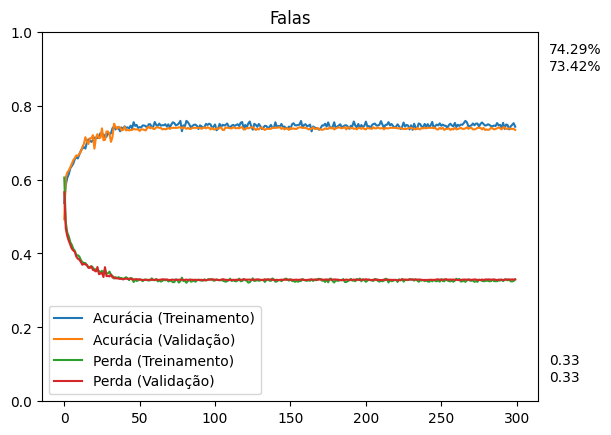

Falas:
              precision    recall  f1-score   support

    $SILENCE       0.73      0.93      0.82       369
         sim       0.73      0.38      0.50       126
         não       0.65      0.38      0.47       112
      talvez       0.82      0.86      0.84       104

    accuracy                           0.73       711
   macro avg       0.73      0.64      0.66       711
weighted avg       0.73      0.73      0.71       711

Training on mouth moving only (no speech)
Original words count: 1839
Original Avg Samples (per word): 204
New words count: 1788 (removed 51 words)
New Avg Samples (per word): 204
New Samples: 193 (removed 11 samples from average)


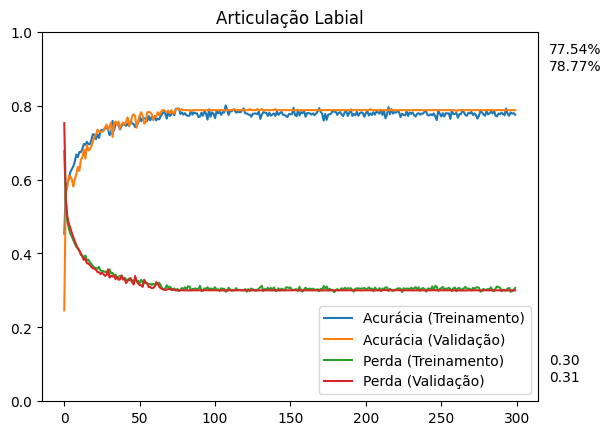

Articulação Labial:
              precision    recall  f1-score   support

    $SILENCE       0.80      0.91      0.85       194
         sim       0.81      0.34      0.48        61
         não       0.79      0.73      0.76        51
      talvez       0.75      0.92      0.83        52

    accuracy                           0.79       358
   macro avg       0.79      0.73      0.73       358
weighted avg       0.79      0.79      0.77       358

Training on subvocalization
Original words count: 1776
Original Avg Samples (per word): 201
New words count: 1737 (removed 39 words)
New Avg Samples (per word): 202
New Samples: 190 (removed 12 samples from average)


/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

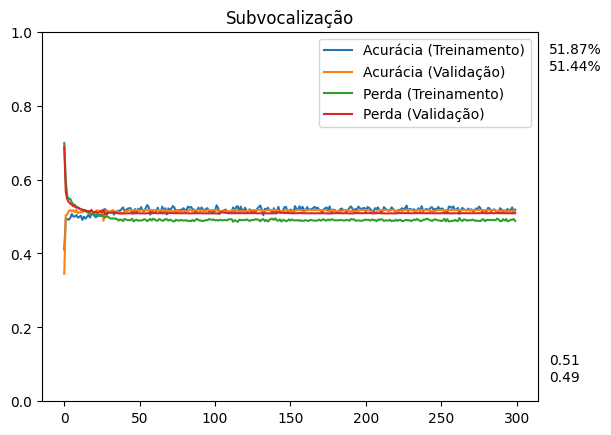

Subvocalização:
              precision    recall  f1-score   support

         sim       0.00      0.00      0.00        53
    $SILENCE       0.52      0.96      0.68       181
         não       0.00      0.00      0.00        63
      talvez       0.38      0.10      0.16        51

    accuracy                           0.51       348
   macro avg       0.23      0.26      0.21       348
weighted avg       0.33      0.51      0.38       348



In [17]:
print("Training real speech recognition")
train_all('Falas', speech)

print("Training on mouth moving only (no speech)")
train_all('Articulação Labial', artic)

print("Training on subvocalization")
train_all('Subvocalização', subv)

In [18]:
participants = list(map(lambda n: "P"+str(n+1).zfill(3), [*range(10)]))
g1 = participants[:5]

P001: True
Original words count: 375
Original Avg Samples (per word): 199
New words count: 370 (removed 5 words)
New Avg Samples (per word): 200
New Samples: 189 (removed 11 samples from average)


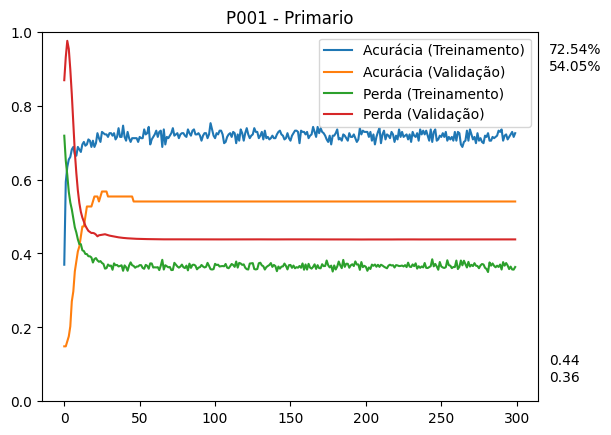

P001 - Primario:
              precision    recall  f1-score   support

    $SILENCE       0.47      0.97      0.63        29
         sim       1.00      0.07      0.13        14
         não       0.00      0.00      0.00        20
      talvez       0.92      1.00      0.96        11

    accuracy                           0.54        74
   macro avg       0.60      0.51      0.43        74
weighted avg       0.51      0.54      0.41        74

Original words count: 375
Original Avg Samples (per word): 200
New words count: 375 (removed 0 words)
New Avg Samples (per word): 200
New Samples: 186 (removed 14 samples from average)


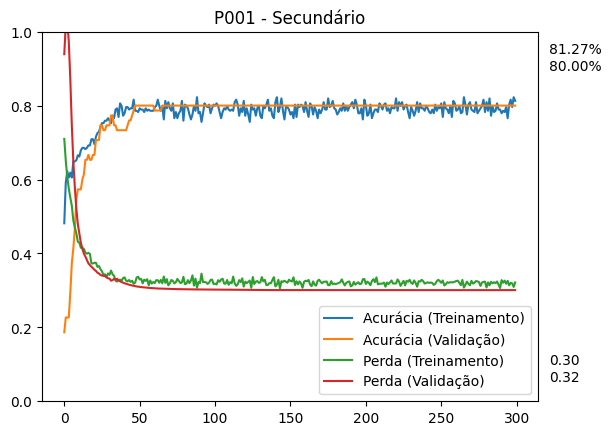

P001 - Secundário:
              precision    recall  f1-score   support

    $SILENCE       0.72      0.88      0.79        32
         sim       0.73      0.57      0.64        14
         não       1.00      0.58      0.74        12
      talvez       0.94      1.00      0.97        17

    accuracy                           0.80        75
   macro avg       0.85      0.76      0.78        75
weighted avg       0.82      0.80      0.79        75

P002: True
Original words count: 375
Original Avg Samples (per word): 200
New words count: 375 (removed 0 words)
New Avg Samples (per word): 200
New Samples: 190 (removed 10 samples from average)


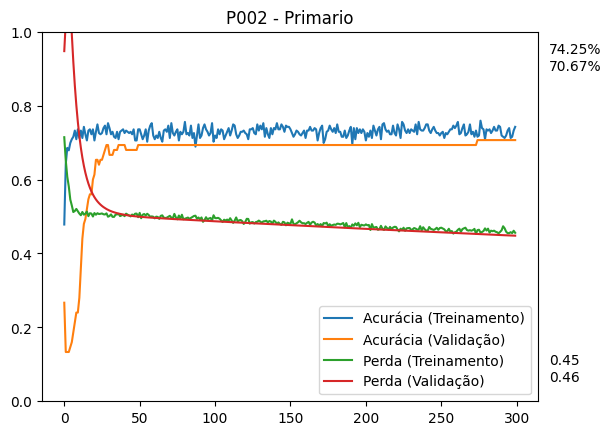

P002 - Primario:
              precision    recall  f1-score   support

    $SILENCE       0.76      0.92      0.83        38
         sim       1.00      0.57      0.73        14
         não       0.00      0.00      0.00        13
      talvez       0.50      1.00      0.67        10

    accuracy                           0.71        75
   macro avg       0.57      0.62      0.56        75
weighted avg       0.64      0.71      0.65        75

Original words count: 375
Original Avg Samples (per word): 200
New words count: 374 (removed 1 words)
New Avg Samples (per word): 200
New Samples: 191 (removed 9 samples from average)


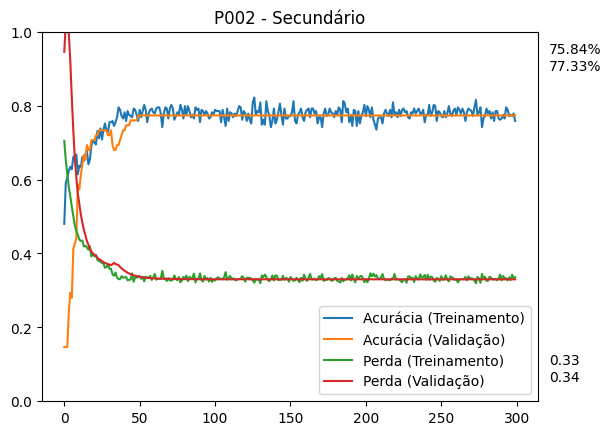

P002 - Secundário:
              precision    recall  f1-score   support

         sim       1.00      0.64      0.78        11
    $SILENCE       0.71      0.97      0.82        38
         não       1.00      0.31      0.48        16
      talvez       0.82      0.90      0.86        10

    accuracy                           0.77        75
   macro avg       0.88      0.71      0.73        75
weighted avg       0.83      0.77      0.75        75

P003: True
Original words count: 375
Original Avg Samples (per word): 200
New words count: 375 (removed 0 words)
New Avg Samples (per word): 200
New Samples: 190 (removed 10 samples from average)


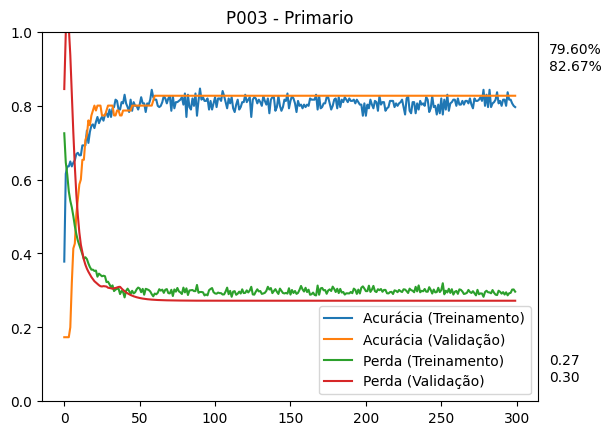

P003 - Primario:
              precision    recall  f1-score   support

         sim       1.00      0.44      0.62         9
    $SILENCE       0.79      0.93      0.85        40
         não       0.75      0.69      0.72        13
      talvez       1.00      0.92      0.96        13

    accuracy                           0.83        75
   macro avg       0.88      0.75      0.79        75
weighted avg       0.84      0.83      0.82        75

Original words count: 366
Original Avg Samples (per word): 204
New words count: 354 (removed 12 words)
New Avg Samples (per word): 205
New Samples: 193 (removed 12 samples from average)


/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

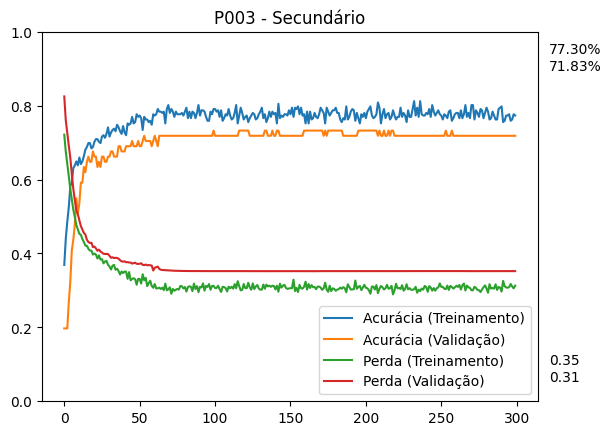

P003 - Secundário:
              precision    recall  f1-score   support

         sim       0.00      0.00      0.00        15
    $SILENCE       0.66      0.97      0.79        34
         não       0.62      0.62      0.62         8
      talvez       1.00      0.93      0.96        14

    accuracy                           0.72        71
   macro avg       0.57      0.63      0.59        71
weighted avg       0.58      0.72      0.64        71

P004: True
Original words count: 315
Original Avg Samples (per word): 214
New words count: 315 (removed 0 words)
New Avg Samples (per word): 214
New Samples: 201 (removed 13 samples from average)


/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

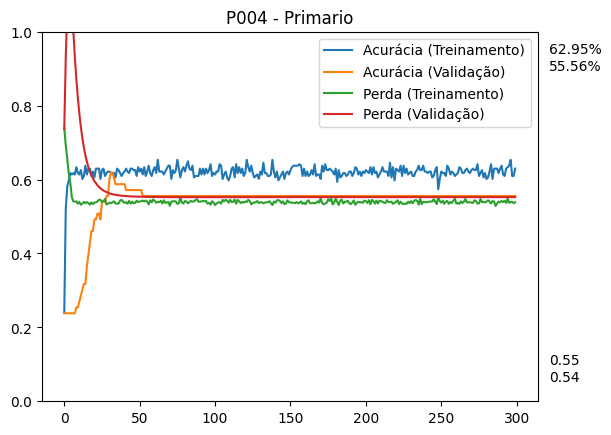

P004 - Primario:
              precision    recall  f1-score   support

         sim       0.00      0.00      0.00         8
    $SILENCE       0.51      0.81      0.63        26
         não       1.00      0.07      0.13        14
      talvez       0.62      0.87      0.72        15

    accuracy                           0.56        63
   macro avg       0.53      0.44      0.37        63
weighted avg       0.58      0.56      0.46        63

Original words count: 348
Original Avg Samples (per word): 214
New words count: 348 (removed 0 words)
New Avg Samples (per word): 214
New Samples: 194 (removed 20 samples from average)


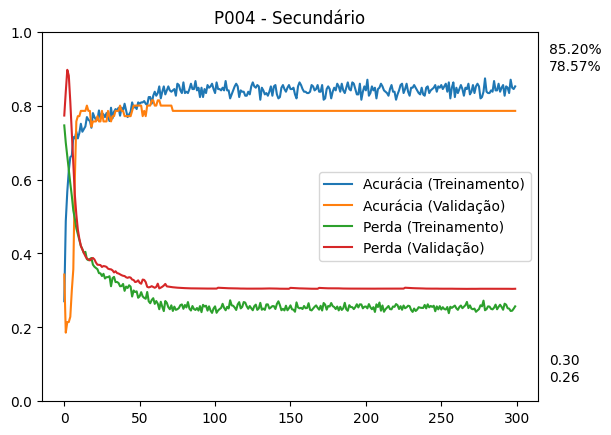

P004 - Secundário:
              precision    recall  f1-score   support

    $SILENCE       0.79      0.92      0.85        37
         sim       0.50      0.09      0.15        11
         não       0.70      0.78      0.74         9
      talvez       0.87      1.00      0.93        13

    accuracy                           0.79        70
   macro avg       0.71      0.70      0.67        70
weighted avg       0.75      0.79      0.74        70

P005: True
Original words count: 375
Original Avg Samples (per word): 200
New words count: 375 (removed 0 words)
New Avg Samples (per word): 200
New Samples: 195 (removed 5 samples from average)


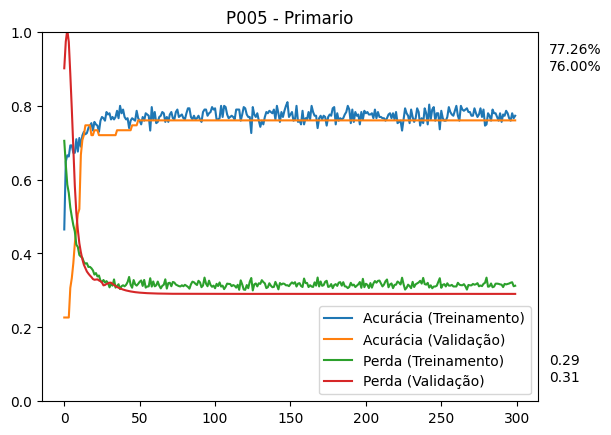

P005 - Primario:
              precision    recall  f1-score   support

         sim       1.00      0.55      0.71        11
    $SILENCE       0.65      0.97      0.78        33
         não       1.00      0.14      0.25        14
      talvez       0.94      1.00      0.97        17

    accuracy                           0.76        75
   macro avg       0.90      0.66      0.68        75
weighted avg       0.83      0.76      0.71        75

Original words count: 375
Original Avg Samples (per word): 200
New words count: 372 (removed 3 words)
New Avg Samples (per word): 200
New Samples: 189 (removed 11 samples from average)


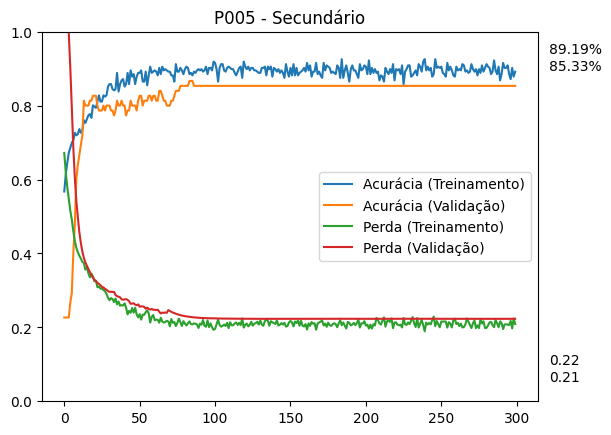

P005 - Secundário:
              precision    recall  f1-score   support

         sim       0.50      0.50      0.50         6
    $SILENCE       0.90      0.95      0.92        38
         não       0.91      0.71      0.80        14
      talvez       0.83      0.88      0.86        17

    accuracy                           0.85        75
   macro avg       0.79      0.76      0.77        75
weighted avg       0.85      0.85      0.85        75

P006: False
Original words count: 375
Original Avg Samples (per word): 200
New words count: 375 (removed 0 words)
New Avg Samples (per word): 200
New Samples: 198 (removed 2 samples from average)


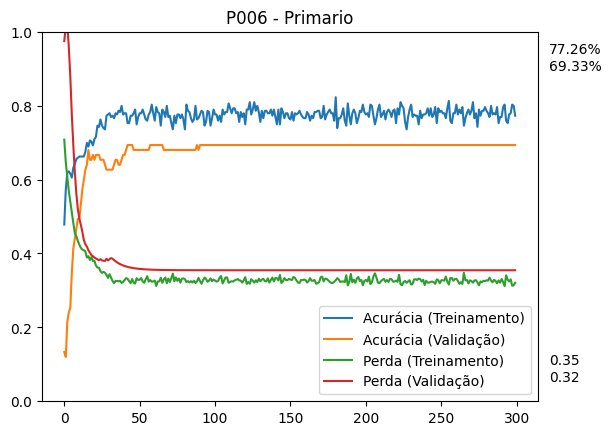

P006 - Primario:
              precision    recall  f1-score   support

         sim       0.60      0.30      0.40        10
    $SILENCE       0.64      0.94      0.76        32
         não       1.00      0.18      0.30        17
      talvez       0.80      1.00      0.89        16

    accuracy                           0.69        75
   macro avg       0.76      0.60      0.59        75
weighted avg       0.75      0.69      0.64        75

Original words count: 375
Original Avg Samples (per word): 200
New words count: 375 (removed 0 words)
New Avg Samples (per word): 200
New Samples: 196 (removed 4 samples from average)


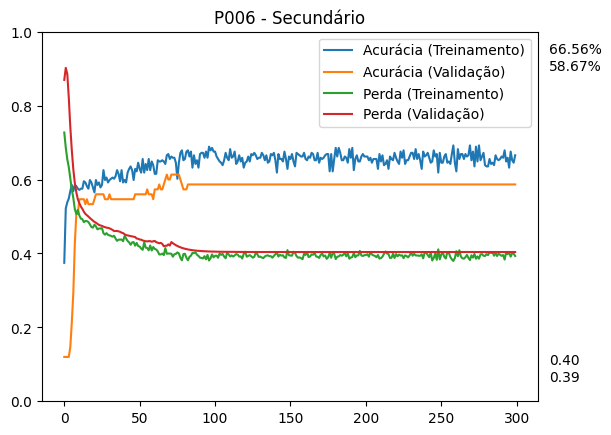

P006 - Secundário:
              precision    recall  f1-score   support

         sim       1.00      0.13      0.24        15
    $SILENCE       0.57      0.95      0.71        37
         não       1.00      0.07      0.13        14
      talvez       0.55      0.67      0.60         9

    accuracy                           0.59        75
   macro avg       0.78      0.45      0.42        75
weighted avg       0.74      0.59      0.50        75

P007: False
Original words count: 375
Original Avg Samples (per word): 200
New words count: 369 (removed 6 words)
New Avg Samples (per word): 200
New Samples: 192 (removed 8 samples from average)


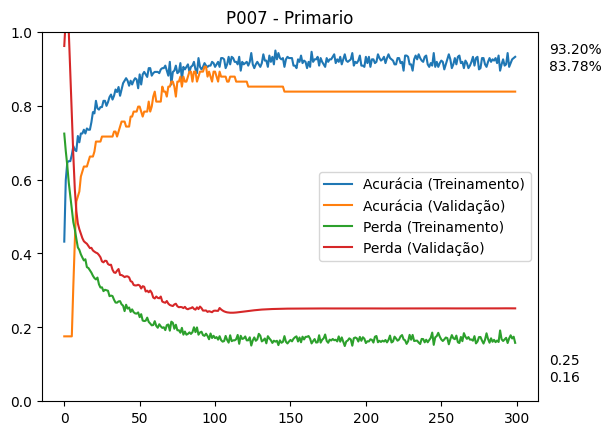

P007 - Primario:
              precision    recall  f1-score   support

    $SILENCE       0.79      1.00      0.89        31
         sim       0.80      0.47      0.59        17
         não       0.91      0.77      0.83        13
      talvez       0.93      1.00      0.96        13

    accuracy                           0.84        74
   macro avg       0.86      0.81      0.82        74
weighted avg       0.84      0.84      0.82        74

Original words count: 375
Original Avg Samples (per word): 200
New words count: 372 (removed 3 words)
New Avg Samples (per word): 200
New Samples: 189 (removed 11 samples from average)


/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

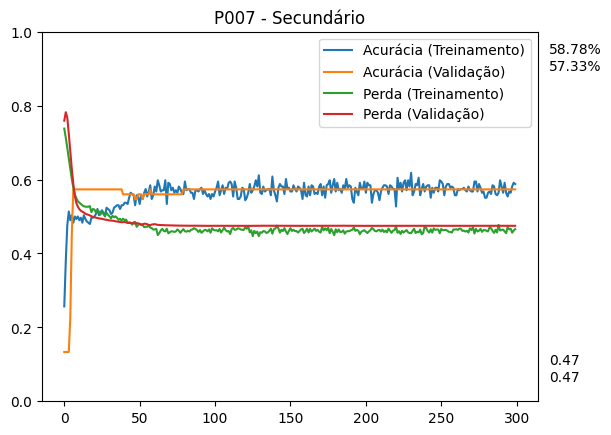

P007 - Secundário:
              precision    recall  f1-score   support

    $SILENCE       0.58      0.95      0.72        43
         sim       0.00      0.00      0.00        10
         não       0.00      0.00      0.00        12
      talvez       0.67      0.20      0.31        10

    accuracy                           0.57        75
   macro avg       0.31      0.29      0.26        75
weighted avg       0.42      0.57      0.45        75

P008: False
Original words count: 375
Original Avg Samples (per word): 200
New words count: 375 (removed 0 words)
New Avg Samples (per word): 200
New Samples: 188 (removed 12 samples from average)


/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

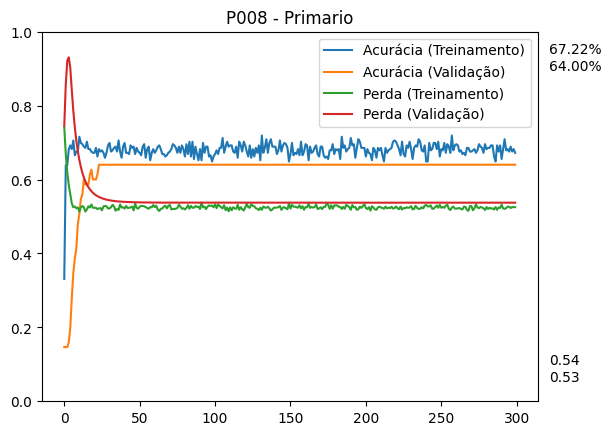

P008 - Primario:
              precision    recall  f1-score   support

         sim       0.00      0.00      0.00        11
    $SILENCE       0.70      0.89      0.79        37
         não       0.67      0.25      0.36        16
      talvez       0.50      1.00      0.67        11

    accuracy                           0.64        75
   macro avg       0.47      0.54      0.45        75
weighted avg       0.56      0.64      0.56        75

Original words count: 375
Original Avg Samples (per word): 200
New words count: 374 (removed 1 words)
New Avg Samples (per word): 200
New Samples: 190 (removed 10 samples from average)


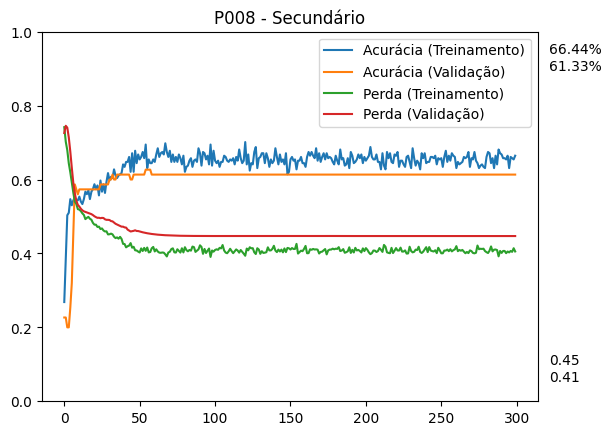

P008 - Secundário:
              precision    recall  f1-score   support

         sim       1.00      0.20      0.33        10
    $SILENCE       0.58      0.97      0.72        35
         não       0.75      0.17      0.27        18
      talvez       0.70      0.58      0.64        12

    accuracy                           0.61        75
   macro avg       0.76      0.48      0.49        75
weighted avg       0.69      0.61      0.55        75

P009: False
Original words count: 336
Original Avg Samples (per word): 200
New words count: 335 (removed 1 words)
New Avg Samples (per word): 200
New Samples: 189 (removed 11 samples from average)


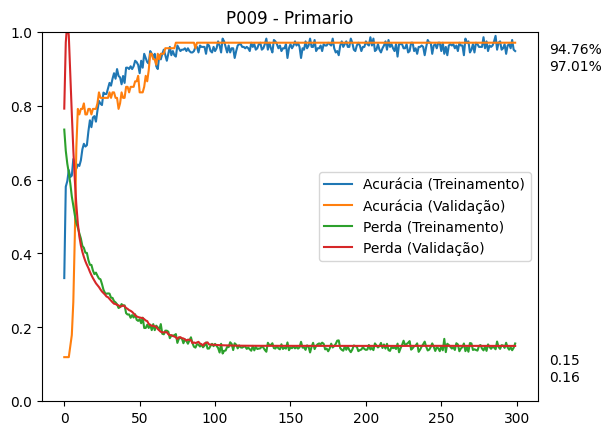

P009 - Primario:
              precision    recall  f1-score   support

         sim       0.89      1.00      0.94         8
    $SILENCE       1.00      0.97      0.99        38
         não       1.00      0.91      0.95        11
      talvez       0.91      1.00      0.95        10

    accuracy                           0.97        67
   macro avg       0.95      0.97      0.96        67
weighted avg       0.97      0.97      0.97        67

Original words count: 336
Original Avg Samples (per word): 200
New words count: 329 (removed 7 words)
New Avg Samples (per word): 200
New Samples: 189 (removed 11 samples from average)


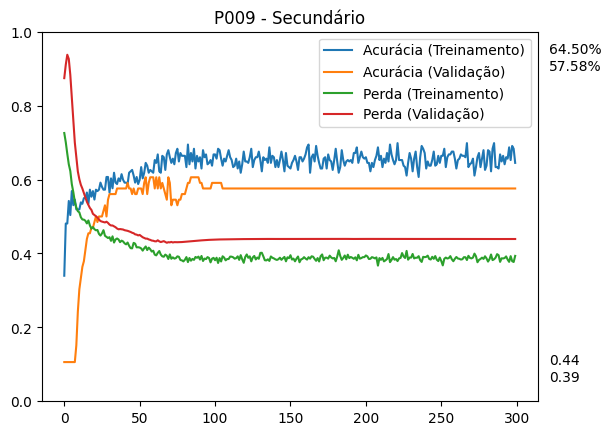

P009 - Secundário:
              precision    recall  f1-score   support

    $SILENCE       0.62      0.72      0.67        36
         sim       0.44      0.36      0.40        11
         não       0.67      0.17      0.27        12
      talvez       0.50      0.86      0.63         7

    accuracy                           0.58        66
   macro avg       0.56      0.53      0.49        66
weighted avg       0.59      0.58      0.55        66

P010: False
Original words count: 315
Original Avg Samples (per word): 212
New words count: 300 (removed 15 words)
New Avg Samples (per word): 215
New Samples: 202 (removed 13 samples from average)


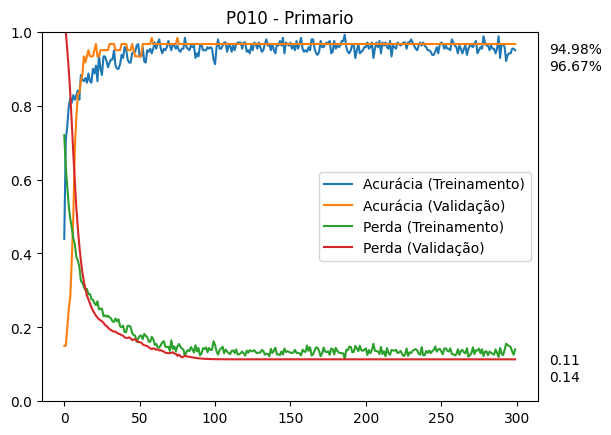

P010 - Primario:
              precision    recall  f1-score   support

    $SILENCE       1.00      1.00      1.00        32
         sim       1.00      1.00      1.00         6
         não       0.83      1.00      0.91        10
      talvez       1.00      0.83      0.91        12

    accuracy                           0.97        60
   macro avg       0.96      0.96      0.95        60
weighted avg       0.97      0.97      0.97        60

Original words count: 315
Original Avg Samples (per word): 206
New words count: 289 (removed 26 words)
New Avg Samples (per word): 214
New Samples: 196 (removed 18 samples from average)


/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mafios/GitHub/subvocalization-emg/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

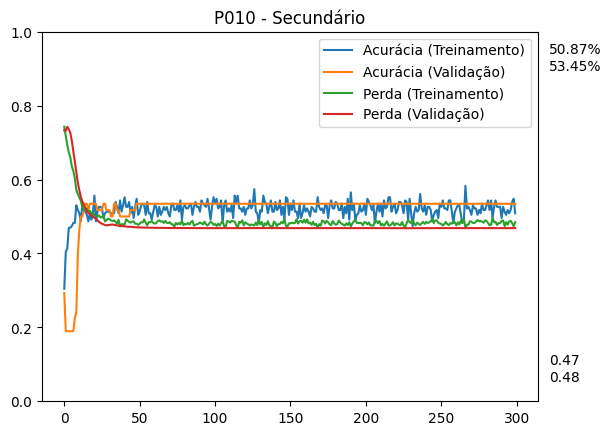

P010 - Secundário:
              precision    recall  f1-score   support

         sim       0.00      0.00      0.00         9
    $SILENCE       0.51      0.93      0.66        28
         não       0.00      0.00      0.00        10
      talvez       0.71      0.45      0.56        11

    accuracy                           0.53        58
   macro avg       0.31      0.35      0.30        58
weighted avg       0.38      0.53      0.42        58



In [19]:
for p in participants:
    print(p+":",p in g1)
    f = [p+"/F/Sim", p+"/F/Nao", p+"/F/Talvez"]
    s = [p+"/A/Sim", p+"/A/Nao", p+"/A/Talvez"] if p in g1 else [p+"/S/Sim", p+"/S/Nao", p+"/S/Talvez"]
    train_all(p+' - Primario', f)
    train_all(p+' - Secundário', s)

## Conclusion

The results demonstrate that this processing and training method is effective for detecting strong gestures, such as speech and articulation. However, for more subtle muscle movements, such as subvocalization, further improvements in noise reduction and data augmentation are necessary.

It is important to note that the same methods, montage, and algorithm yielded varying results across different participants. Some exhibited lower accuracy in detecting easily recognizable speech, while others achieved higher accuracy in identifying less discernible subvocalizations.